# 介绍

电子邮件营销是当今数字经济中最具成本效益和影响力的客户互动工具之一。通过电子邮件，企业能够个性化与用户的沟通，推广新功能，并引导用户访问网站。然而，电子邮件营销的真正潜力不仅体现在其便捷性上，更在于通过数据驱动的方式优化营销活动表现。

本项目将对一次电子邮件营销活动进行分析，目的在于评估活动的效果并回答以下关键问题：有多少用户打开了邮件？有多少用户点击了邮件中的链接？此外，我们将利用机器学习模型来优化未来的邮件营销活动，旨在最大化用户点击邮件链接的概率，并探索不同用户群体的营销表现差异。

# 导入数据集

导入一些的库：

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [54]:
import warnings
warnings.filterwarnings("ignore")

导入数据集：

In [34]:
open_data = pd.read_csv("./../dataset/07. email/email_opened_table.csv")
open_data.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [35]:
email_data = pd.read_csv('./../dataset/07. email/email_table.csv')
email_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [36]:
link_data = pd.read_csv("./../dataset/07. email/link_clicked_table.csv")
link_data.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


查看一下三个数据的情况：

In [37]:
# check uniqueness of email_id in three tables
print('email_table.csv:\t', len(email_data['email_id'].unique()))
print('email_opened_table.csv:\t', len(open_data['email_id'].unique()))
print('link_clicked_table.csv:\t', len(link_data['email_id'].unique()))

email_table.csv:	 100000
email_opened_table.csv:	 10345
link_clicked_table.csv:	 2119


# 数据处理

对数据进行合并：

In [38]:
# create new columns `opened` and `clicked`
open_data['opened'] = 1
link_data['clicked'] = 1
data = pd.merge(left=email_data, right=open_data, how='left', on='email_id')
data = pd.merge(left=data, right=link_data, how='left', on='email_id')
data = data.fillna(value=0)

In [39]:
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)

In [40]:
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [41]:
data.tail()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
99995,803504,short_email,personalized,4,Monday,US,5,0,0
99996,899722,long_email,personalized,7,Saturday,US,1,0,0
99997,449610,long_email,personalized,11,Saturday,UK,6,0,0
99998,72497,short_email,generic,10,Monday,UK,0,0,0
99999,348333,long_email,personalized,8,Sunday,UK,1,1,1


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   opened               100000 non-null  int32 
 8   clicked              100000 non-null  int32 
dtypes: int32(2), int64(3), object(4)
memory usage: 6.1+ MB


# 邮件转换情况

通过非零值来判断一下转换率：

In [43]:
# 计算打开邮件的百分比
opened_percentage = (data['opened'].sum() / len(data)) * 100
print(f"打开邮件的百分比为: {opened_percentage:.2f}%")

打开邮件的百分比为: 10.35%


In [44]:
# 计算点击率（占所有接收邮件的用户的比率）
click_rate_total = (data['clicked'].sum() / len(data)) * 100
print(f"点击率（总体）：{click_rate_total:.2f}%")

# 计算点击率（占打开邮件的用户的比率）
click_rate_opened = (data[data['opened'] == 1]['clicked'].sum() / data['opened'].sum()) * 100
print(f"点击率（打开邮件的用户）：{click_rate_opened:.2f}%")

点击率（总体）：2.12%
点击率（打开邮件的用户）：20.00%


绘制漏斗图：

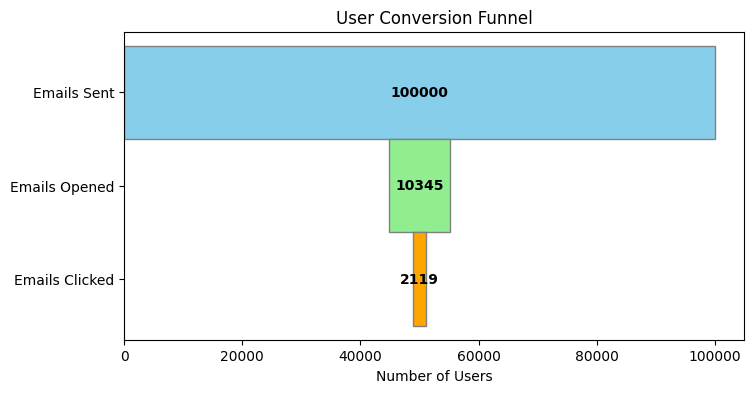

In [45]:
# 定义数据
funnel_stages = {
    'Emails Sent': total_emails,
    'Emails Opened': opened_emails,
    'Emails Clicked': clicked_emails
}

# 定义每个阶段的高度和颜色
height = 1  # 每个条形的高度
levels = list(funnel_stages.values())
colors = ['skyblue', 'lightgreen', 'orange']  # 不同阶段使用不同颜色
labels = list(funnel_stages.keys())
y_pos = range(len(levels), 0, -1)  # y轴位置，从上往下排列

# 创建绘图
fig, ax = plt.subplots(figsize=(8, 4))

# 绘制漏斗的每一层
for i in range(len(levels)):
    x_range = max(levels) / 2 - levels[i] / 2  # 计算每个条形的水平起始位置
    ax.barh(y_pos[i], levels[i], height=height, left=x_range, color=colors[i], edgecolor='gray')
    ax.text(x_range + levels[i] / 2, y_pos[i], f'{levels[i]}', va='center', ha='center', color='black', fontweight='bold')

# 设置y轴标签
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Number of Users')
ax.set_title('User Conversion Funnel')

# 显示图形
plt.show()

# 邮件点击率优化

## 不同的特征

**点击率**

首先查看一下点击率和非点击率的比较：

In [46]:
data.groupby('clicked')['email_id'].count() / len(data)

clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

可以发现只有2.12%的邮件中的链接被点击了。

**长短文**

查看一下文件的长短对链接点击率的影响：

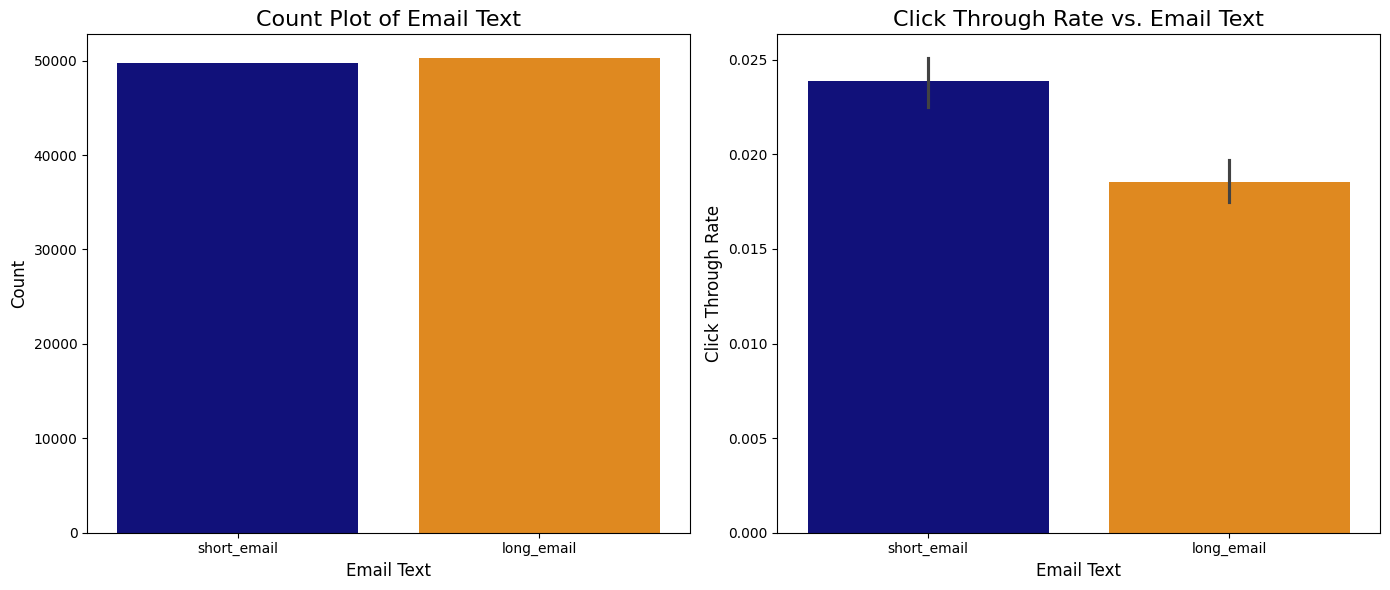

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))  # 设置为一行两列大小14*6

palette_count = ['darkblue', 'darkorange']  # 假设有两个类别
sns.countplot(x = "email_text", data = data, ax = ax[0], palette=palette_count)
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1], palette=palette_count)
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

从可视化的结果来看，short_email和long_email在数量上并没有什么差异，但是short_email的点击率明显的高于了long_email。

但是我们需要进行假设性检验来进行判断。


1. **收集数据和初步统计**:
   - 首先，我们需要确定每种邮件（短邮件和长邮件）的点击总数和未点击总数。这里的“点击”是成功事件，“未点击”是失败事件。

2. **计算点击率**:
   - 点击率是指点击邮件的人数占邮件总发送量的比例。这是我们比较的核心指标。

3. **标准误差的计算**:
   - 在比较两个比例时，关键是确定这两个比例的差异是否超出了随机波动的范围。这就需要计算这个差异的标准误差（Standard Error, SE）。
   - 标准误差公式是：$ SE = \sqrt{\frac{p_1 \times (1 - p_1)}{n_1} + \frac{p_2 \times (1 - p_2)}{n_2}} $
   - 其中 $p_1$ 和 $p_2$ 是两组的成功概率（点击率），$n_1$ 和 $n_2$ 是两组的观测数量。

4. **Z 分数计算**:
   - Z 分数是比例差异除以标准误差。这个分数表示比例差异是多少个标准误差：
   - $Z = \frac{(p_1 - p_2)}{SE}$

5. **P 值和结论**:
   - 使用 Z 分数，我们可以从标准正态分布中计算出一个 P 值。P 值表示在零假设（即两组间无差异）为真的情况下，观察到当前或更极端比例差异的概率。
   - 根据 P 值与设定的显著性水平（如 0.05）比较，我们可以决定是否拒绝零假设。

In [56]:
from statsmodels.stats.proportion import proportions_ztest

# 计算各组的成功次数和总数
short_emails = data[data['email_text'] == 'short_email']
long_emails = data[data['email_text'] == 'long_email']

success_short = short_emails['clicked'].sum()
total_short = short_emails['clicked'].count()
success_long = long_emails['clicked'].sum()
total_long = long_emails['clicked'].count()

# 进行 Z-检验
count = np.array([success_short, success_long])
nobs = np.array([total_short, total_long])
stat, pval = proportions_ztest(count, nobs)

print('Z-statistic:', stat)
print('P-value:', pval)

Z-statistic: 5.856118747168301
P-value: 4.738094975953786e-09


检验结果显示了非常明显的统计显著性：

- Z-statistic: 5.856：这个值表明观测到的比例差距在标准误差的度量下有5.856个标准差之远。这是一个相当大的值，表示两组数据之间存在显著的差异。
- P-value: 4.738e-09：P 值非常小，远小于常用的显著性水平（如0.05或0.01）。这意味着在零假设（短邮件和长邮件点击率无差异）为真的情况下，观察到这样或更极端的结果的概率极低。

根据这些结果，我们可以拒绝零假设，即短邮件和长邮件的点击率没有差异的假设。实际上，这表明短邮件的点击率显著高于长邮件的点击率。这个结果为电子邮件营销提供了非常有用的见解，表明短邮件可能更有效地吸引接收者的注意力和行动。

**邮件类型**

接着查看普通的邮件和个人化的邮件，对点击率的影响：

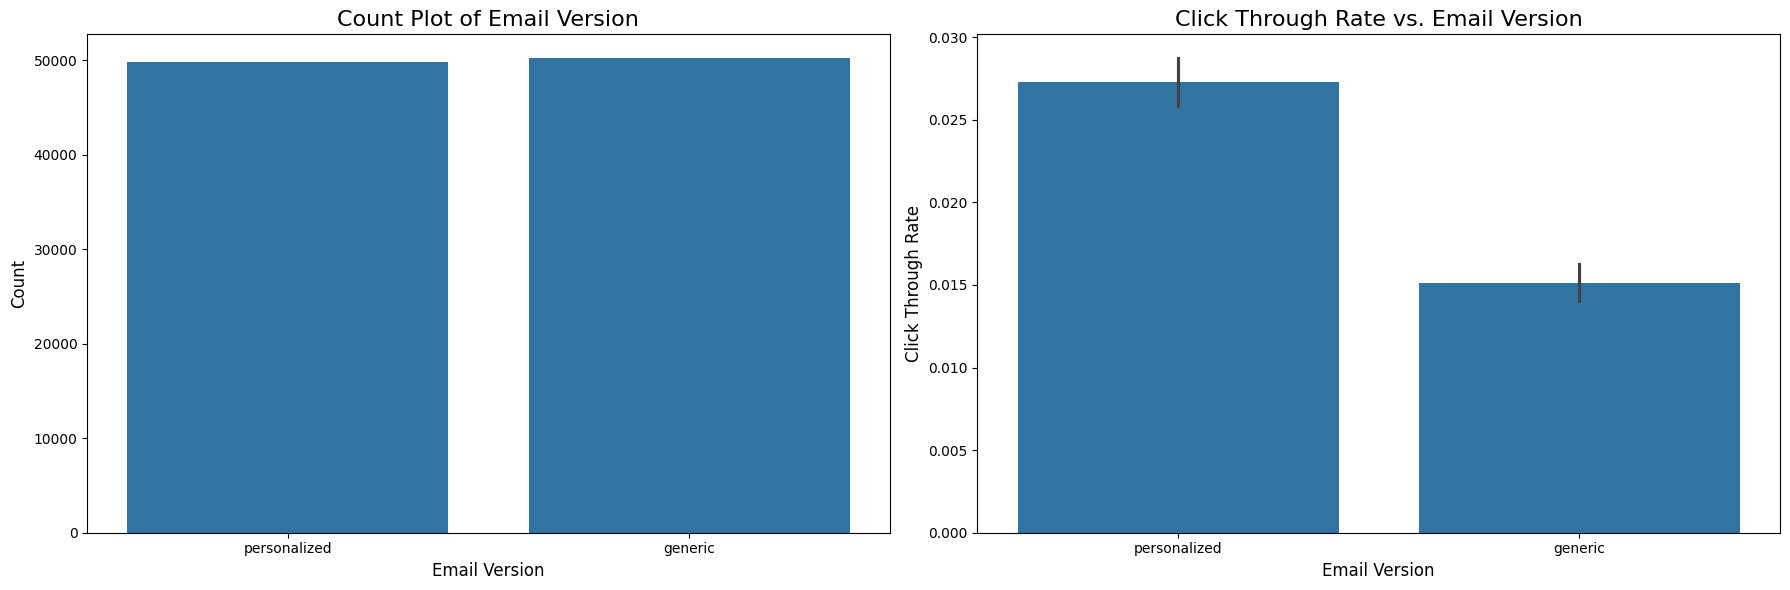

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

可以发现两种类型的邮件发送的差不多，但是个性化的邮件的点击率明显的高于了普通的邮件。

In [58]:
# 筛选出个性化和通用邮件的数据
personalized_emails = data[data['email_version'] == 'personalized']
generic_emails = data[data['email_version'] == 'generic']

# 计算各组的成功次数和总数
success_personalized = personalized_emails['clicked'].sum()
total_personalized = personalized_emails['clicked'].count()
success_generic = generic_emails['clicked'].sum()
total_generic = generic_emails['clicked'].count()

# 进行 Z-检验
count = np.array([success_personalized, success_generic])
nobs = np.array([total_personalized, total_generic])
stat, pval = proportions_ztest(count, nobs)

print('Z-statistic:', stat)
print('P-value:', pval)

Z-statistic: 13.347220627379018
P-value: 1.2295132171191242e-40


得到了非常明显的统计显著性：

- **Z-statistic: 13.347**：这个值表明观测到的比例差异在标准误差的度量下有13.347个标准差之远，这是一个极其显著的统计值，表明两组数据之间存在非常大的差异。
- **P-value: $1.23 \times 10^{-40}$**：这个极小的 P 值远远小于任何常规的显著性水平（例如 0.05 或 0.01），这意味着在零假设（个性化邮件和通用邮件点击率无差异）为真的情况下，观察到这样或更极端的结果的概率几乎为零。

这些结果强烈表明，个性化邮件和通用邮件在引发点击方面存在显著的效果差异。具体来说，个性化邮件的点击率显著高于通用邮件，这为电子邮件营销提供了重要的策略指导：个性化邮件内容显著提高了用户的参与度。这种发现支持了在电子邮件营销活动中更广泛地采用个性化策略的决策，可能包括更针对性的消息、定制化的推荐和更有针对性的用户群体定位。这些措施都可能进一步优化营销效果，提高整体的转化率和用户满意度。

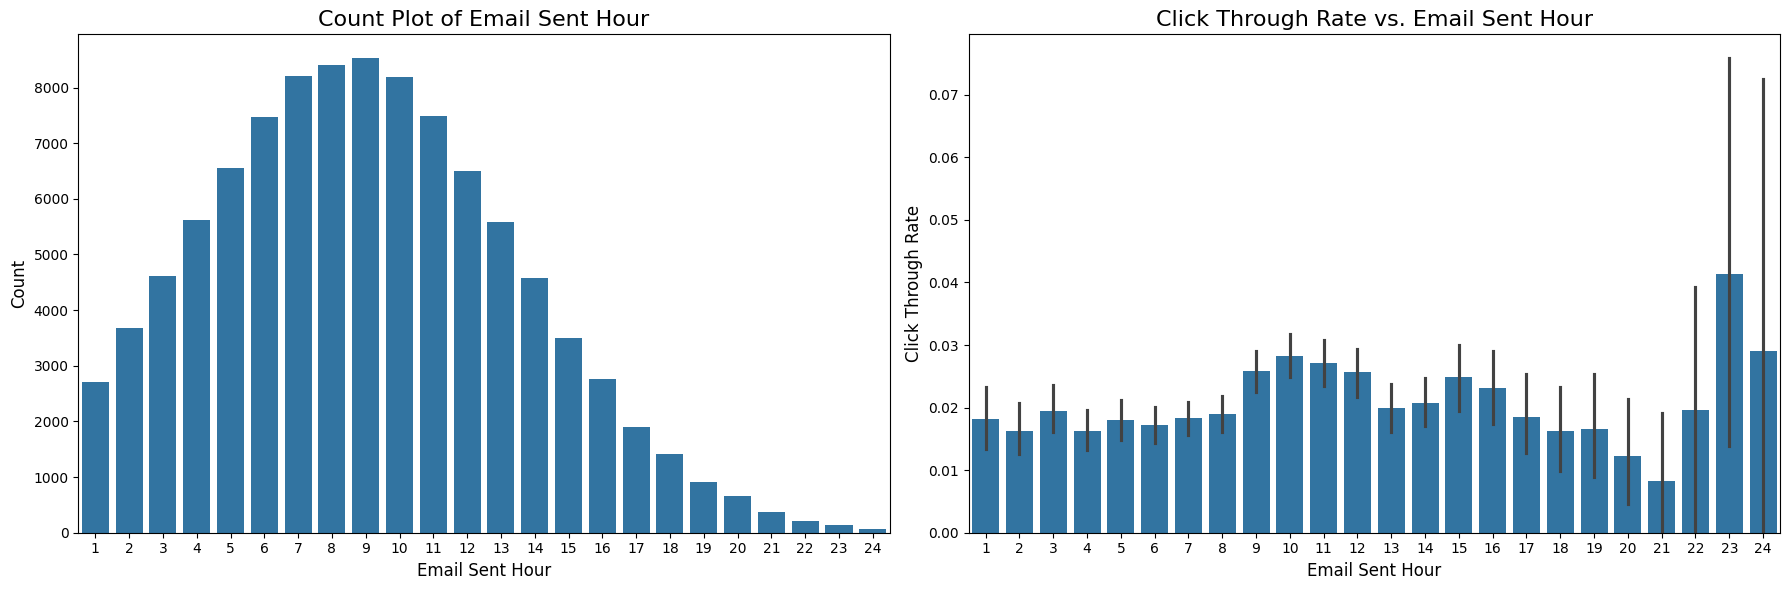

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

这张图表显示了一天中每个小时发送电子邮件的数量。从图中可以看出，电子邮件发送量从早上6点开始逐渐增多，至上午10点达到峰值。此后，发送量逐渐下降，直到晚上8点之后急剧减少。电子邮件的发送高峰时段集中在上午8点至下午3点之间。这可能反映了工作时间内电子邮件活动的集中。

这张图表显示了一天中每个小时发送的电子邮件的平均点击率，带有误差棒表示变异情况。点击率在一天中的不同时间显示出较大的波动，尤其在晚上和凌晨的点击率波动较大，表明少量的邮件发送可能导致点击率数据变化较大。尽管邮件发送量在早晨到下午达到高峰，但点击率并没有明显的高峰，这表明发送时间并不是影响点击率的唯一因素。值得注意的是，午夜前后（23点至凌晨1点）的点击率有显著提升，这可能是因为这一时间段内用户较少接收新邮件，从而更可能注意到并点击已接收的邮件。

In [63]:
# 确保 `hour` 列为整数类型
data['hour'] = data['hour'].astype(int)

# 实验组：晚上10点到凌晨1点
experimental_emails = data[data['hour'].isin([22, 23, 0, 1])]

# 对照组：白天10点到下午1点
control_emails = data[data['hour'].isin([10, 11, 12, 13])]

# 计算点击次数和邮件总数
success_exp = experimental_emails['clicked'].sum()
total_exp = experimental_emails['clicked'].count()
success_ctrl = control_emails['clicked'].sum()
total_ctrl = control_emails['clicked'].count()

# 进行 Z-检验
count = np.array([success_exp, success_ctrl])
nobs = np.array([total_exp, total_ctrl])
stat, pval = proportions_ztest(count, nobs)

print('Z-statistic:', stat)
print('P-value:', pval)

Z-statistic: -2.122870862322118
P-value: 0.03376467471511276


Z-statistic: -2.123：Z统计量的值是-2.123，这表示实验组的结果在统计上低于对照组。Z统计量的负值指出实验组（晚上10点到凌晨1点发送的电子邮件）的平均点击率低于对照组（白天10点到下午1点发送的电子邮件）。

P-value: 0.03376：P值为0.03376，小于常用的显著性水平0.05，这意味着我们有足够的证据拒绝零假设。零假设通常是两组之间不存在差异。因此，根据这个P值，我们可以认为晚上发送的邮件点击率与白天发送的邮件点击率存在显著差异。

可以采用的策略：
- 发送时间调整：根据发送量和点击率的信息，调整邮件发送的时间可能对提高用户的参与度有积极影响。例如，尽管早晨发送邮件数量多，但考虑到用户可能一上班就收到大量邮件，调整到午后可能更有利于邮件被注意和点击。
- 针对性策略：晚上和午夜前后点击率的提高表明，可以针对这些时间段发送重要或紧急的营销邮件，以期获得更高的用户互动。
- 持续监测和测试：持续监测各时间段的点击率和发送量，并通过A/B测试等方法进一步验证最佳发送时间，以实现电子邮件营销的最优化。

**周几**

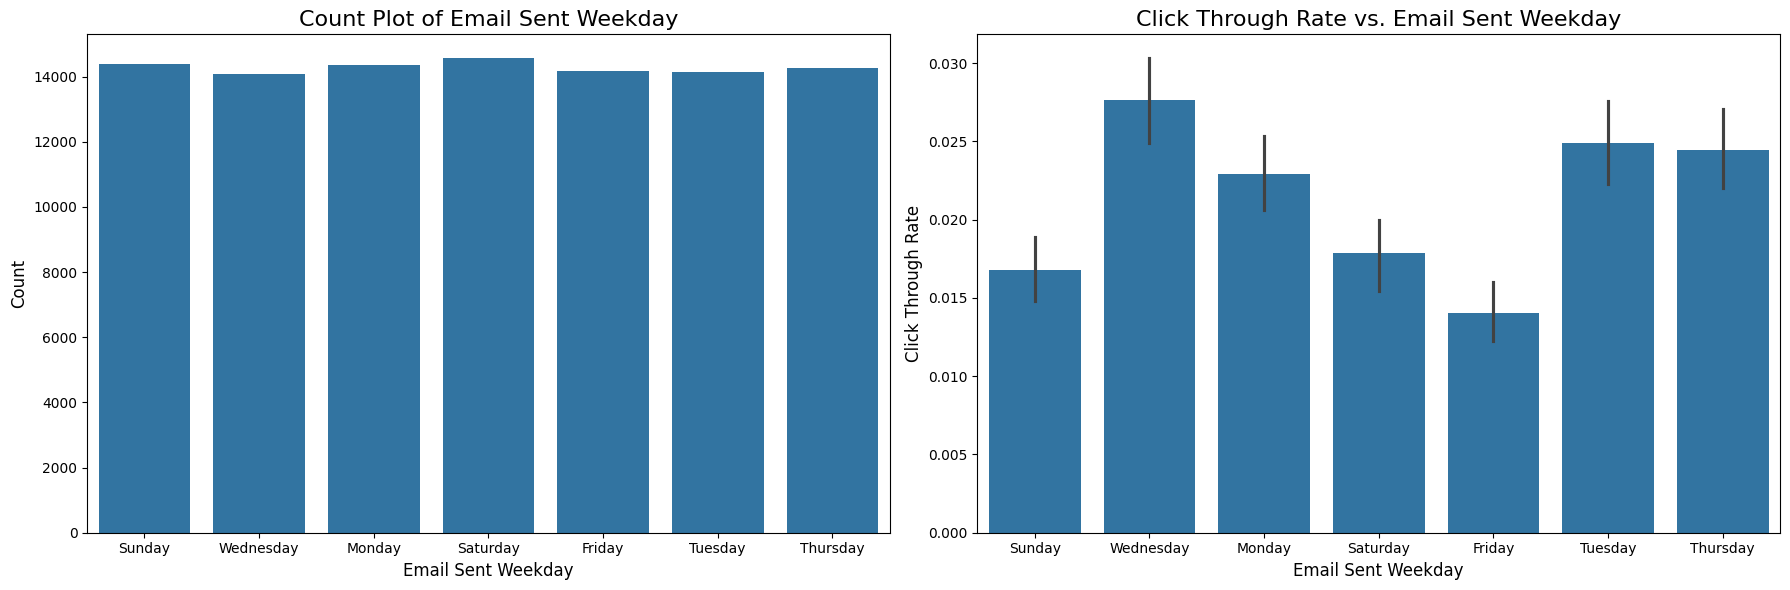

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

这两张图表提供了关于电子邮件发送和点击率在一周中不同工作日的分布和效率的视觉分析：

**计数图（Count Plot of Email Sent Weekday）：**

- 此图表显示了一周中每天发送电子邮件的数量。
- 可以观察到，周日至周四的电子邮件发送量相对较稳定，每天约有12000至13000封邮件发送。周五和周六的发送量略有下降，尤其是周六，发送量明显减少。
- 这种分布可能反映了企业在工作日进行电子邮件营销活动的常规模式，而在周末时减少营销邮件的发送。

**点击率图（Click Through Rate vs. Email Sent Weekday）：**

- 此图表展示了一周中每天发送的电子邮件的平均点击率，其中包括误差棒以表示变异程度。
- 显然，周一的点击率最高，随后是周四和周日。这表明在周初和周末开始时发送的邮件可能获得更多的用户互动。
- 周五和周六的点击率较低，这可能与周末人们更少关注工作相关邮件的习惯有关。
- 点击率的波动显示出，尽管发送量在周中相对稳定，用户的互动行为仍受周中特定日子的影响。

**分析和策略建议**

- **发送策略优化**：鉴于周一和周四的点击率较高，建议在这些天发送重要或需要较高用户参与的邮件，以提高点击率和邮件效果。
- **考虑用户行为**：周五和周六的低点击率可能与周末休息和减少查看电子邮件的行为有关，建议减少这两天的营销邮件发送量，或调整邮件内容以吸引用户的注意力。
- **持续测试和评估**：通过持续监测和分析每天的邮件发送效果和用户反应，调整邮件发送计划，尝试不同的发送时间和内容策略，并通过A/B测试确定最有效的方法。

这些数据和分析可以帮助营销团队更有效地规划和执行他们的电子邮件营销策略，以最大化用户参与度和营销投资回报。

**用户的国家**

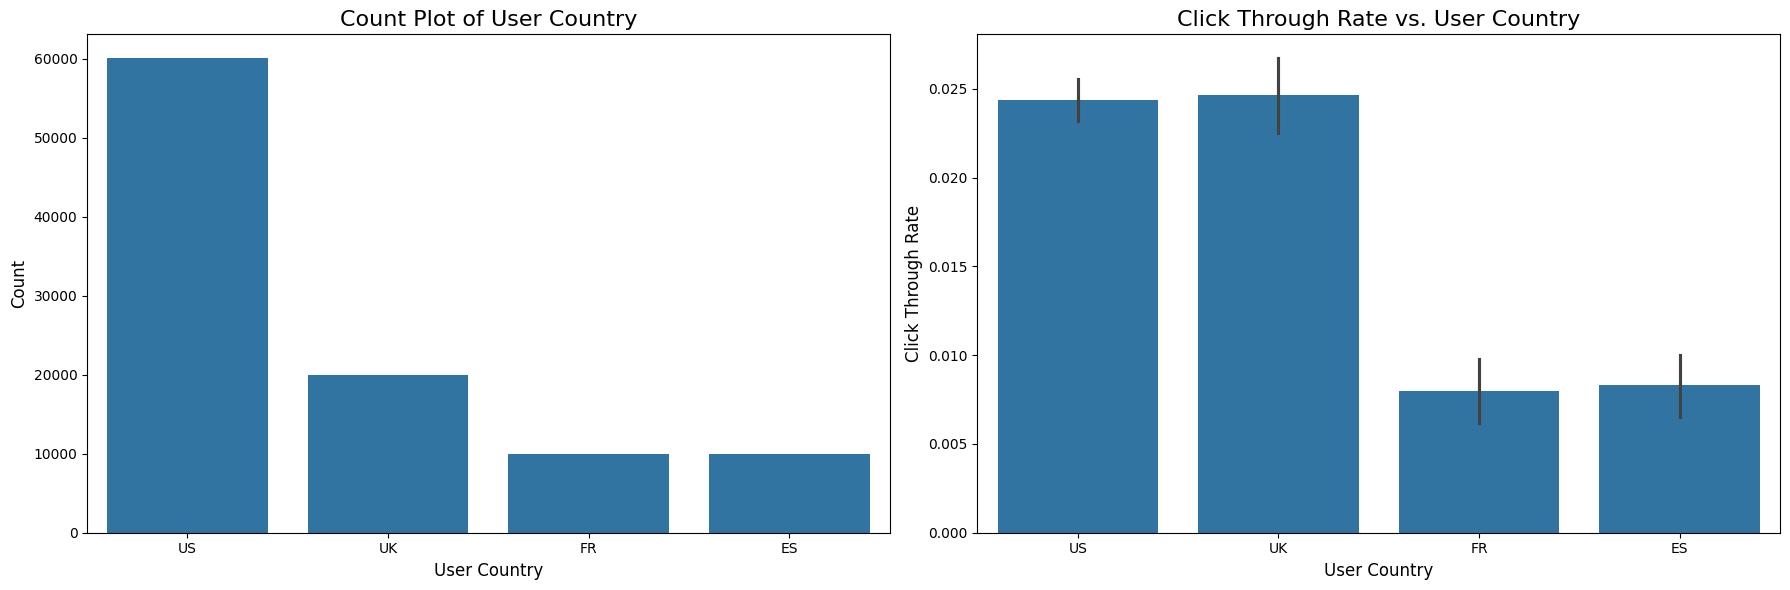

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

这两幅图表展示了按用户所在国家分类的电子邮件发送数量及其点击率的统计数据：

**计数图（Count Plot of User Country）**

- 第一张图表显示了不同国家用户接收的电子邮件数量。
- 美国（US）用户接收的邮件数量远多于其他国家，是接收量最高的国家，接近60,000封。英国（UK）位列第二，约有20,000封邮件。法国（FR）和西班牙（ES）的邮件数量大致相当，每个国家接收的邮件数都在10,000封左右。
- 这种分布可能反映了各国市场在电子邮件营销策略中的重要性或用户基数大小。

**点击率图（Click Through Rate vs. User Country）**

- 第二张图表展示了这些国家用户对电子邮件点击的响应率。
- 英国用户的点击率最高，约为0.02，即平均每100封邮件中有2次点击。美国紧随其后，点击率略低，但仍在同一数量级。法国和西班牙的点击率相对较低，两者的点击率非常接近，每100封邮件大约有1次点击。
- 误差棒显示，尽管英国和美国的点击率较高，但误差范围也相对较大，这表明点击率数据在这些国家内部可能存在较大的变异性。

**分析与策略建议**

- **市场定位**：数据显示，尽管美国接收了最多的电子邮件，但英国的点击率却是最高的。这表明在英国市场上，电子邮件营销策略可能更有效，而美国市场尽管邮件发送量大，但转化率提升的空间可能更大。
- **优化策略**：对于点击率较低的法国和西班牙市场，可能需要调整邮件内容或发送策略，例如通过更加个性化的邮件内容或改进调用动作（CTA）的设计来提高用户的参与度。
- **细分市场**：进一步分析每个国家用户的具体偏好和行为模式，对邮件发送时间、内容风格进行更细致的调整，可能会提高所有市场的点击率。

这些数据为进一步优化和调整跨国电子邮件营销策略提供了基础，有助于提高各国市场的用户参与度和电子邮件营销的整体效果。

**过去购物数量**

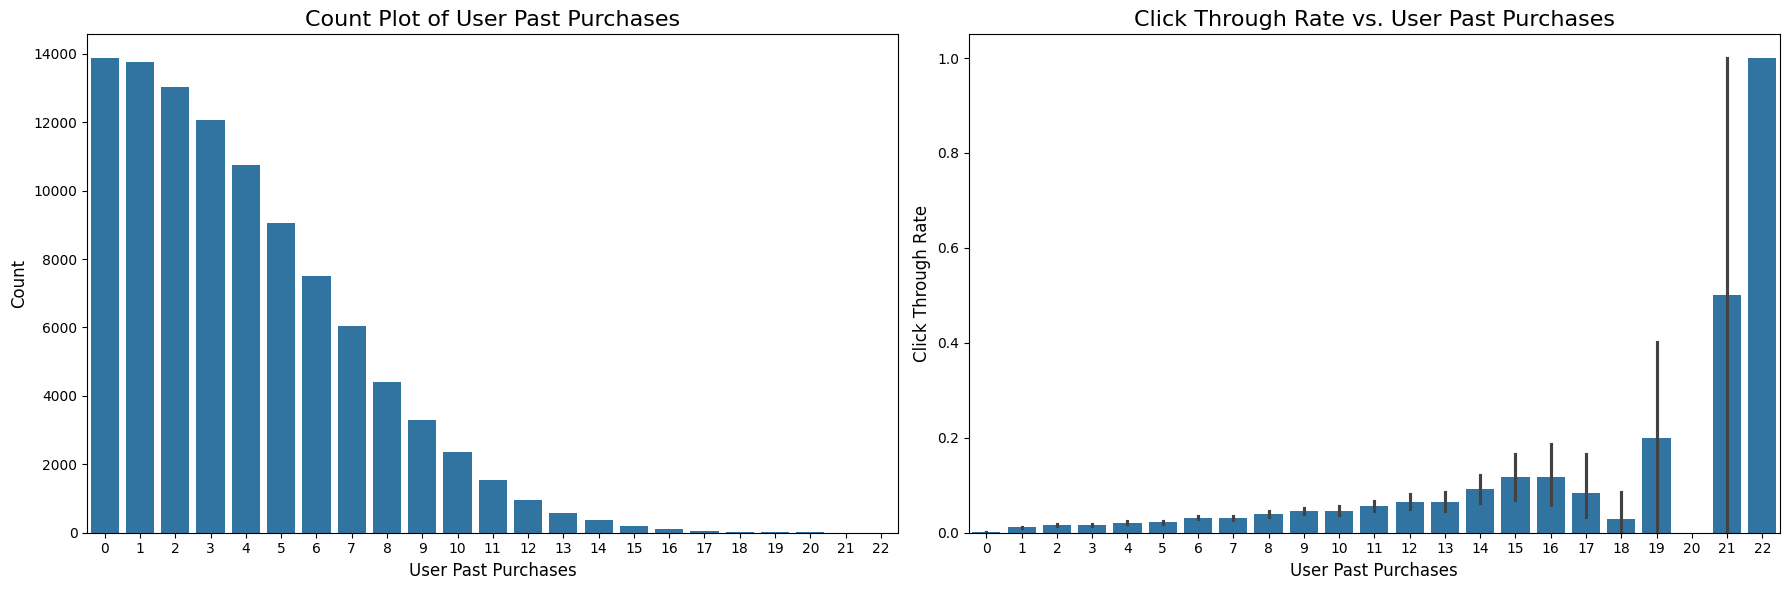

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

这两幅图表提供了关于用户历史购买次数与电子邮件点击率之间关系的视觉展示：

**计数图（Count Plot of User Past Purchases）**

- 第一幅图显示了用户基于他们过去的购买次数接收电子邮件的分布情况。
- 大多数用户的历史购买次数较少，具体来说，购买次数为0次的用户接收的邮件数量最多，随着购买次数的增加，接收邮件的用户数量逐渐减少。这显示了用户群体中新客户的比例高于老客户。
- 对于那些购买次数在1至5次之间的用户，他们仍然占据了相对较高的邮件接收比例。然而，当购买次数超过5次后，接收邮件的用户数量急剧下降，尤其是在购买次数超过10次以上的用户中，这部分用户的数量显著减少。

**点击率图（Click Through Rate vs. User Past Purchases）**

- 第二幅图表展示了不同历史购买次数的用户的电子邮件点击率。
- 对于大多数购买次数类别，点击率保持在相对较低的水平，其中多数集中在0.0至0.05之间。这表明大多数用户对电子邮件的反应相对一致，与他们的购买历史无明显正相关关系。
- 然而，对于那些历史购买次数非常高的用户（如20次及以上），点击率显著增高，达到接近1.0的水平。这表明高频购买用户对邮件的反应性和参与度远高于其他用户。
- 需要注意的是，这些高点击率的数据点也伴随着较大的误差棒，这可能是因为样本量较小，导致统计上的波动较大。

**分析与策略建议**

- **目标精准化**：数据表明，虽然大多数用户的点击率较低，但高频购买用户的点击率异常高。这提供了一种策略，即通过更加个性化和针对性的电子邮件营销来更好地服务于这些高价值用户。
- **增强用户忠诚度**：鉴于具有中等购买历史的用户群体较大，采取措施提高这部分用户的活跃度和购买频次可能会带来整体点击率的提升。
- **长期跟踪与维护**：对于新用户或低频用户，开发一系列促进用户忠诚度和提升参与度的策略，例如通过提供优惠、忠诚度奖励或更有针对性的内容，可能会逐渐提高这些用户群的点击率。

通过这些详细的分析，企业可以更有效地利用其数据，根据用户的购买历史优化电子邮件营销策略，从而提高用户的参与度和转化率。

## 随机森林模型

In [69]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [70]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Temurin)(build 25.422-b05, mixed mode)
  Starting server from C:\Users\wangjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\wangjun\AppData\Local\Temp\tmplnw9b7bx
  JVM stdout: C:\Users\wangjun\AppData\Local\Temp\tmplnw9b7bx\h2o_wangjun_started_from_python.out
  JVM stderr: C:\Users\wangjun\AppData\Local\Temp\tmplnw9b7bx\h2o_wangjun_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,"7 days, 2 hours and 54 minutes"
H2O_cluster_name:,H2O_from_python_wangjun_khddcm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.489 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [71]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\wangjun\AppData\Local\Temp\ipykernel_27608\1862535490.py:5: H2ODeprecationWarning: ``summary()`` is deprecated, please use ``show_summary()`` or ``get_summary()`` instead
  h2o_df.summary()


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.196160002,,,9.059300000000048,,,3.8784500000000173,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.727534294,,,4.4396374417069655,,,3.19610978357714,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0.0,0


In [88]:
# Split into 75% training and 25% test dataset
# 使用 stratified_split 方法。这种方法是确保数据集分割时，不同分类的比例保持一致
strat_split = h2o_df['clicked'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [73]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1725518765972_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         507756                 10           10           10            248           497           398.65

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.45561811518566614
RMSE: 0.6749949001182647
LogLoss: 1.6198705401237
Mean Per-Class Error: 0.2255801952937174
AUC: 0.8588161421232815
AUCPR: 0.83057375054727
Gini: 0.717632284246563

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01688298799789376
       0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      45194  28217  0.3844   (28217.0/73411.0)
1      4902   68492  0.0668   (4902.0/73394.0)
Total  50096  96709  0.2256   (33119.0/146805.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.016883     0.8053    325
max f2                       0.0118836    0.899933  346
max f0point5                 0.0274922    0.767267  282
max accuracy                 0.0196532    0.777201  314
max precision                0.26951      1         0
max recall                   0.00545752   1         372
max specificity              0.26951      1         0
max absolute_mcc             0.016883     0.57879   325
max min_per_class_accuracy   0.0272722    0.767011  283
max mean_per_class_accuracy  0.0196532    0.777214  314
max tns                      0.26951      73411     0
max fns                      0.26951      73393     0
max fps                      5.01548e-05  73411     399
max tps                      0.00545752   73394     372
max tnr                      0.26951      1         0
max fnr                      0.26951      0.999986  0
max fpr                      5.01548e-05  1         399
max tpr                      0.00545752   1         372

Gains/Lift Table: Avg response rate: 49.99 %, avg score:  3.15 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100065                   0.114815           1.94168    1.94168            0.970728         0.131466     0.970728                    0.131466            0.0194294       0.0194294                  94.1682   94.1682            0.0188436
2        0.0200061                   0.100735           1.90077    1.92123            0.950272         0.107003     0.960504                    0.119239            0.019007        0.0384364                  90.0765   92.123             0.0368562
3        0.0300058                   0.0918869          1.85171    1.89806            0.925749         0.0960342    0.948922                    0.111506            0.0185165       0.0569529                  85.1713   89.8063            0.0538879
4        0.0400054                   0.0859044          1.81356    1.87694            0.906676         0.0887379    0.938362                    0.105815            0.018135        0.0750879                  81.3562   87.6941            0.0701567
5        0.0500051                   0.0811804          1.84763    1.87108            0.923706         0.0834529 

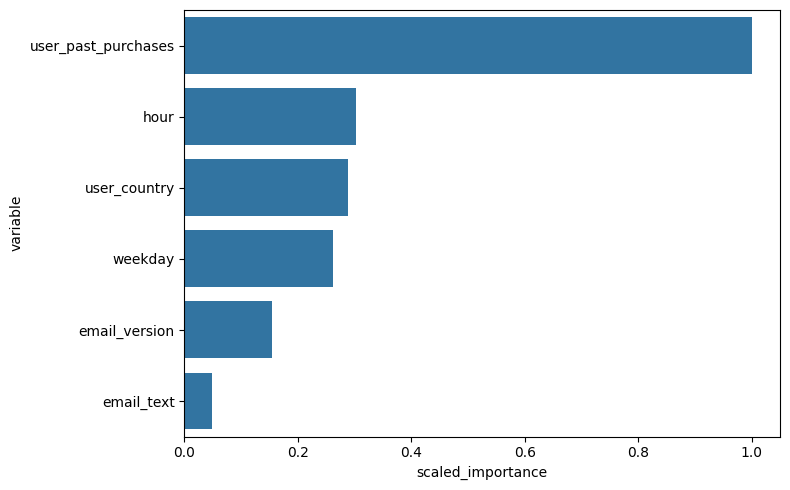

In [74]:
# 查看重要的特征变量
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

尝试进行预测：

In [76]:
from sklearn.metrics import auc, roc_curve, classification_report
# Make predictions
train_true = train.as_data_frame()['clicked'].values
test_true = test.as_data_frame()['clicked'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

drf prediction progress: |

C:\Users\wangjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\wangjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

C:\Users\wangjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000



C:\Users\wangjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


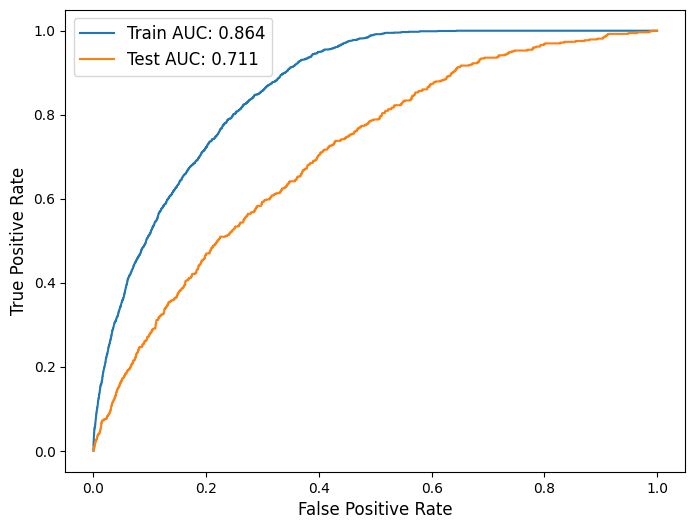

In [77]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

- 蓝线（训练数据）：训练数据的 AUC 值为 0.864，表明模型在训练集上具有较好的区分正负样本的能力。曲线相对于对角线的提升较高，显示出模型能较好地识别出正类。
- 橙线（测试数据）：测试数据的 AUC 值为 0.711，虽然仍显示出一定的分类能力，但显著低于训练集。这表明模型在未见过的数据上的表现下降，可能存在一定程度的过拟合。

生成模型的偏依赖图（Partial Dependence Plot, PDP）。偏依赖图是一种可视化工具，用来分析一个或多个特征对预测结果的影响，同时忽略其他特征的影响。这样的图表可以帮助你理解模型在不同特征值下的行为。

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


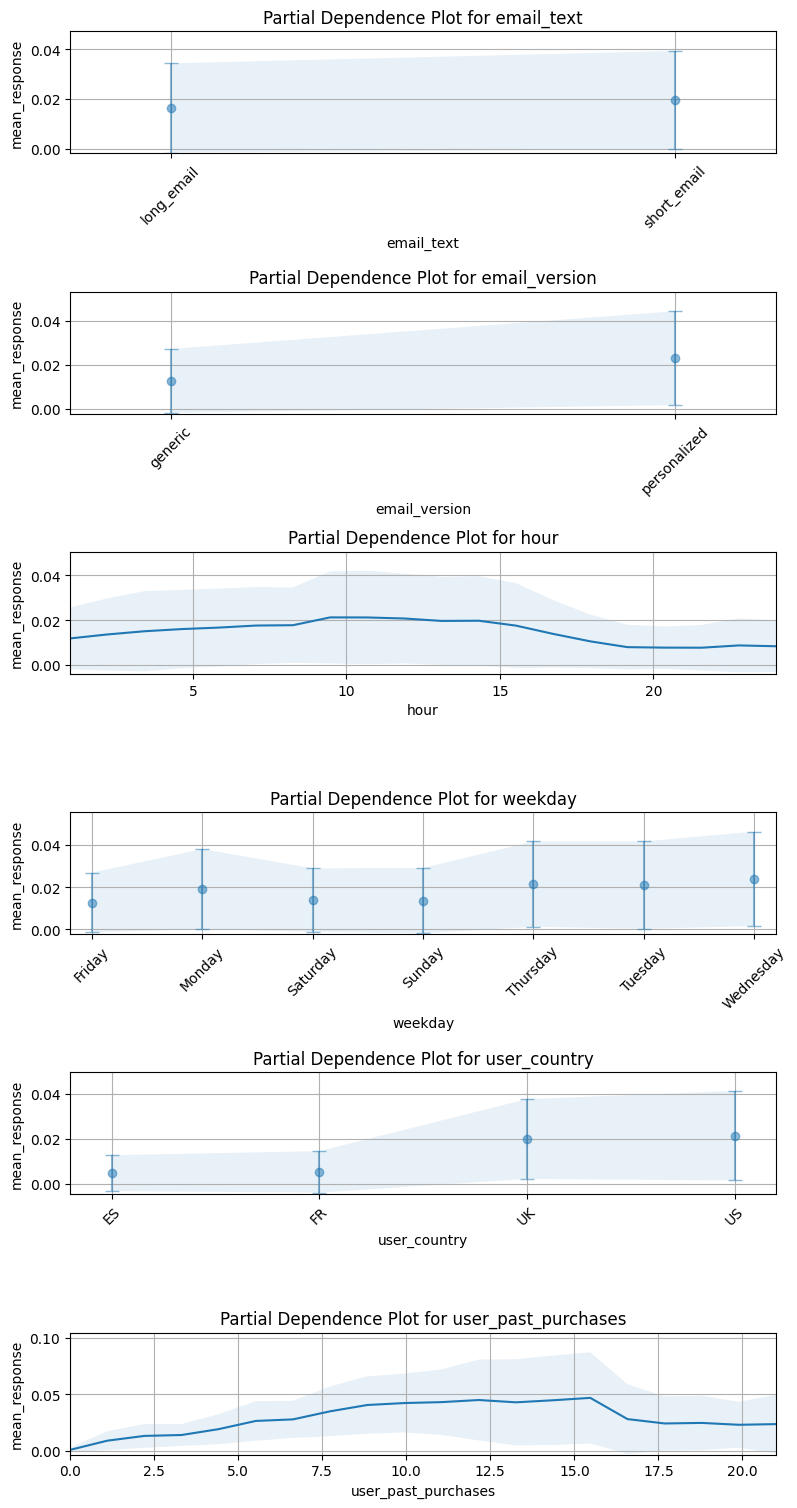

In [89]:
# Partial dependence plot
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [90]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_bb4b closed.


为了验证我们的预测模型是否有效提升电子邮件营销的点击率，我们计划实施一项A/B测试。这项测试将用户随机分为对照组和实验组两部分：

1. **对照组**：这一组的用户将按照传统的电子邮件营销策略接收邮件，这意味着所有用户都会收到相同的营销邮件，不考虑他们是否可能点击链接。
2. **实验组**：与此同时，实验组的用户将接受基于模型的筛选。我们的模型将预测哪些用户更可能点击邮件中的链接，只有被预测为"可能点击"的用户才会收到营销邮件。

**数据收集与分析方法**

在A/B测试期间，我们将详细记录两组用户的互动数据，尤其是他们对电子邮件的点击行为。测试结束后，我们将使用单尾非配对t检验来比较两组之间的点击率差异。此统计检验的目的是确定实验组用户的点击率是否显著高于对照组用户的点击率，我们的假设是实验组的点击率会更高。

**测试的目的和预期结果**

这次A/B测试的主要目标是评估通过模型预测来优化邮件发送目标用户群是否可以有效提高用户的点击率。如果实验结果表明实验组的点击率显著高于对照组，那么这将证明我们的模型在实际应用中的有效性。成功的测试结果不仅可以支持公司采用更加个性化的电子邮件营销策略，还可以帮助我们进一步优化模型，以更精准地识别和影响潜在客户。

通过这种方式，我们旨在科学地验证预测模型的实际效用，并确保电子邮件营销活动的策略调整是基于坚实的数据分析基础。这将帮助公司更有效地利用营销资源，提升营销活动的整体效率和效果。